# Predicting the next closing candlestick on the Ethereum Daily Chart

This notebook aims to estimate the next daily candlestick of Ethereum using only technical information that is available on a candlestick chart today.

The initial motivation is to test the hypothesis that the next candlestick can be approximated by the candlestick before. However, this proved to be somewhat beyond my current understanding of a multi-dependent variable estimation model.

As such I decided to simplify the problem by predicting only the next possible candlestick **cluster** instead of the exact candlestick

## Disclaimer

** The contents, estimations, and predictions in this notebook is meant solely for research and educational purposes (mostly for my own learning) and should not be taken as investment advice. Neither the author nor anyone else distributing this notebook is liable for any losses that occur from using the information in this notebook. **

## Rationale

When traders employ technical analysis, the key information they look at to derive buy or sell signals are the patterns of the candlestick formations. These patterns are defined and recognised by looking at the lengths of each portion of a candlestick relative to the other parts (eg. evening star, morning star, marubozu, dojis, spinning tops, hammers etc).

The buy and sell signals are further enhanced by looking at candlestick patterns preceding the current one, both independently and as combinations.

However, how can we confirm that these pre-defined candlestick patterns are supposed to work as they are intended to? We may be wrong from the start.

As such, instead of manually identifying the candlestick formations based on prior knowledge obtained from various republished sources, we will let the model explore the data and form its own patterns. (eg. imagine a whole new set of stars, marubozus, dojis, tops, hammers etc)

## Assumptions

1) All fundamental information are already incorporated in the price <br>


2) Prices are driven entirely by price action in a continuous and simultaneous game, where investors can observe each other's moves before making their own move, or initiate a move to pre-empt the moves of others <br>


3) New news releases that have a significant impact may still move prices beyond the prediction capabilities of the model

## Methodology

I will be downloading the full historical price data of the Ethereum daily chart from coinmarketcap.

This dataset comes with the **Date, Open, High, Low, Close, Volume, Market Cap ** features.

I will further engineer 12 new features (but will not use all of them for clustering) from the candlestick data available, these will be as follows:

1) **bodyLength** - This is derived as **Open** minus **Close**. The body length of a candle shows the magnitude of the buying/selling pressure <br>

2) **upperWick** - This is derived as **High** minus **Open/Close** depending on the 'colour' of the candlestick. The upper wick length of a candlestick represents the extent of profit-taking during the day <br>

3) **lowerWick** - This is derived as **Low** minus **Open/Close** depending on the 'colour' of the candlestick. The lower wick length of a candlestick represents the extent of bulls-buying-the-dip <br>

4) **CandleLength** - This is derived as **High** minus **Low**. The total candle length indicates the overall price movement during the day. Shorter lengths signifies consolidation and longer lengths signifies volatility. <br>

5) **body%** - This is derived as **bodyLength/candleLength**. Similar to **body** the ratio of a candlestick's body to its total length shows the magnitude of buying/selling pressure, with an additional data point of being relative to its total candle length. This is useful for showing the body length relative to its time period <br>

6) **lowerWick%** - This is derived as **lowerWick/candleLength**. Similar to **lowerWick** the ratio of a candlestick's lower wick to its total length shows the magnitude of profit-taking, with an additional data point of being relative to its total candle length. This is useful for showing the lower wick length relative to its time period<br>

7) **upperWick%** - This is derived as **upperWick/candleLength**. Similar to **lowerWick** the ratio of a candlestick's upper wick to its total length shows the magnitude of bulls-buying-the-dip, with an additional data point of being relative to its total candle length. This is useful for showing the upper wick length relative to its time period<br>

8) **lower/upper** - This is derived as **lowerWick/upperWick**. The ratio of the length of a candlesticks lower wick to its upper wick shows how much profit-taking there is compared to bulls-buying-the-dip <br>

9) **lower/body** - This is derived as **lowerWick/bodyLength**. The ratio of the length of a candlesticks lower wick to its body length shows how much bulls-buying-the-dip there is compared to the price range where most of the trading activity occurs. Supposedly, when this ratio is high, the chances of an uptrend increases substantially <br>

10) **upper/body** - This is derived as **upperWick/bodyLength**. The ratio of the length of a candlesticks upper wick to its body length shows how much profit-taking there is compared to the price range where most of the trading activity occurs. Supposedly, when this ratio is high, the chances of an downtrend increases substantially 

11) **volumeChange** - This is derived as **volume[d]/volume[d-1]**. This represents current day's volume as a percentage of the previous day's and is useful to show a standardised volume metric across all time periods

12) **McapChange** - This is derived as **Market Cap[d]/Market Cap[d-1]**. This represents current day's Market Cap as a percentage of the previous day's and is useful to show a standardised Market Cap metric across all time periods

In [1]:
# Import the basic data wrangling libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats

In [2]:
# Load the dataset
df_pre = pd.read_csv('ethprice240817.csv')

In [3]:
# '''Uncomment if need to add one new row for new day's data'''

# data = []

# data.insert(0, {'Date': '18-Aug-17', 'Open': 301.70, 'High': 307.96, 'Low': 292.50, 'Close': 295.59, 
#                 'Volume': '936,160,000', 'Market Cap': '28,380,200,000'})

# ethDailyPrice = pd.concat([pd.DataFrame(data), ethDailyPrice_pre], ignore_index=True)

In [4]:
# Comment out if need to add new row for new day's data
# ethDailyPrice = ethDailyPrice_pre 

In [5]:
df = df_pre.iloc[::-1]
df.index = df_pre.index[::0]
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,"164,329",-
1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,"674,188","167,911,000"
2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,"532,170","42,637,600"
3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,"405,283","43,130,000"
4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,"1,463,100","42,796,500"


In [7]:
ethDailyPrice = df

#### Create new features

In [8]:
ethDailyPrice['bodyLength'] = (ethDailyPrice['Close'] - ethDailyPrice['Open'])/ethDailyPrice['Open']

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
ethDailyPrice.head()

,Date,Open,High,Low,Close,Volume,Market Cap,bodyLength
0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,"164,329",-,-0.021201
1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,"674,188","167,911,000",-0.729991
2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,"532,170","42,637,600",-0.006003
3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,"405,283","43,130,000",-0.007761
4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,"1,463,100","42,796,500",0.511114


In [11]:
tempList = []

for i, value in enumerate(ethDailyPrice['bodyLength']):
    if value > 0:
        upperWick = (ethDailyPrice['High'][i] - ethDailyPrice['Close'][i])/ethDailyPrice['Open'][i]
    else:
        upperWick = (ethDailyPrice['High'][i] - ethDailyPrice['Open'][i])/ethDailyPrice['Open'][i]
    
    tempList.append(upperWick)

In [12]:
ethDailyPrice['upperWick'] = tempList

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
tempList = []

for i, value in enumerate(ethDailyPrice['bodyLength']):
    if value > 0:
        lowerWick = (ethDailyPrice['Low'][i] - ethDailyPrice['Open'][i])/ethDailyPrice['Open'][i]
    else:
        lowerWick = (ethDailyPrice['Low'][i] - ethDailyPrice['Close'][i])/ethDailyPrice['Open'][i]
    
    tempList.append(lowerWick)

In [14]:
ethDailyPrice['lowerWick'] = tempList

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
ethDailyPrice.head()

,Date,Open,High,Low,Close,Volume,Market Cap,bodyLength,upperWick,lowerWick
0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,"164,329",-,-0.021201,0.250883,-0.088339
1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,"674,188","167,911,000",-0.729991,0.003584,-0.013835
2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,"532,170","42,637,600",-0.006003,0.245950,-0.102963
3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,"405,283","43,130,000",-0.007761,0.022220,-0.100705
4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,"1,463,100","42,796,500",0.511114,0.084735,-0.063342


In [16]:
ethDailyPrice['candleLength'] = (ethDailyPrice['High'] - ethDailyPrice['Low'])/ethDailyPrice['Open']

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
ethDailyPrice['body%'] = ethDailyPrice['bodyLength']/ethDailyPrice['candleLength']
ethDailyPrice['lowerWick%'] = abs(ethDailyPrice['lowerWick'])/ethDailyPrice['candleLength']
ethDailyPrice['upperWick%'] = ethDailyPrice['upperWick']/ethDailyPrice['candleLength']
ethDailyPrice['lower/upper'] = ethDailyPrice['lowerWick%']/ethDailyPrice['upperWick%']
ethDailyPrice['lower/body'] = ethDailyPrice['lowerWick%']/ethDailyPrice['body%']
ethDailyPrice['upper/body'] = ethDailyPrice['upperWick%']/ethDailyPrice['body%']

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [18]:
ethDailyPrice['lower/upper'].fillna(0, inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
tempCol = ethDailyPrice['lower/upper']
tempCol.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [20]:
tempCol.max()

2008.9999999917848

In [21]:
ethDailyPrice['lower/upper'].fillna(tempCol.max(), inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [22]:
tempCol = ethDailyPrice['lower/body']
tempCol.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [23]:
tempCol.max()

501.88571428507885

In [24]:
ethDailyPrice['lower/body'].fillna(tempCol.max(), inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [25]:
tempCol = ethDailyPrice['upper/body']
tempCol.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [26]:
tempCol.max()

158.86666666646528

In [27]:
ethDailyPrice['upper/body'].fillna(tempCol.max(), inplace=True)

/Users/samuelclk/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Convert 'Volume' and 'Market Cap' data from str to int

In [31]:
ethDailyPrice['Volume'] = ethDailyPrice['Volume'].apply(lambda i: int(i.replace(',', '')))

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
ethDailyPrice['Market Cap'] = ethDailyPrice['Market Cap'].apply(lambda i: i.replace(',', ''))
ethDailyPrice['Market Cap'] = ethDailyPrice['Market Cap'].apply(lambda i: i.replace('-', '0'))
ethDailyPrice['Market Cap'] = ethDailyPrice['Market Cap'].apply(lambda i: int(i))

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [33]:
# change in volume %
p_today = [i for i in ethDailyPrice['Volume'][0:ethDailyPrice.shape[0]-1]]
p_yesterday = [i for i in ethDailyPrice['Volume'][1:]]

tempList = []

for i, j in enumerate(p_today):
    x = p_today[i]/p_yesterday[i]
    tempList.append(x)
tempList.insert(ethDailyPrice.shape[0] - 1, 0)
ethDailyPrice['volumeChange'] = tempList
ethDailyPrice

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,Open,High,Low,Close,Volume,Market Cap,bodyLength,upperWick,lowerWick,candleLength,body%,lowerWick%,upperWick%,lower/upper,lower/body,upper/body,Close_d+1,volumeChange
0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,164329,0,-0.021201,0.250883,-0.088339,0.360424,-0.058824,0.245098,0.696078,0.352113,-4.166667,-11.833333,0.000000,0.243744
1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,674188,167911000,-0.729991,0.003584,-0.013835,0.747410,-0.976694,0.018511,0.004796,3.860000,-0.018952,-0.004910,2.770000,1.266866
2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,532170,42637600,-0.006003,0.245950,-0.102963,0.354916,-0.016914,0.290106,0.692980,0.418635,-17.151687,-40.970512,0.753325,1.313082
3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,405283,43130000,-0.007761,0.022220,-0.100705,0.130685,-0.059384,0.770588,0.170028,4.532115,-12.976358,-2.863202,0.701897,0.277003
4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,1463100,42796500,0.511114,0.084735,-0.063342,0.659192,0.775364,0.096091,0.128544,0.747533,0.123930,0.165786,0.708448,0.680315
5,12-Aug-15,1.060000,1.290000,0.883608,1.220000,2150620,64018400,0.150943,0.066038,-0.166408,0.383389,0.393709,0.434044,0.172247,2.519886,1.102450,0.437500,1.070000,0.528579
6,13-Aug-15,1.220000,1.970000,1.170000,1.830000,4068680,73935400,0.500000,0.114754,-0.040984,0.655738,0.762500,0.062500,0.175000,0.357143,0.081967,0.229508,1.220000,0.877432
7,14-Aug-15,1.810000,2.260000,1.750000,1.830000,4637030,109594000,0.011050,0.237569,-0.033149,0.281768,0.039216,0.117647,0.843137,0.139535,3.000000,21.500000,1.830000,1.815339
8,15-Aug-15,1.800000,1.880000,1.570000,1.690000,2554360,109160000,-0.061111,0.044444,-0.066667,0.172222,-0.354839,0.387097,0.258065,1.500000,-1.090909,-0.727273,1.830000,0.719378
9,16-Aug-15,1.680000,1.700000,1.090000,1.570000,3550790,102028000,-0.065476,0.011905,-0.285714,0.363095,-0.180328,0.786885,0.032787,24.000000,-4.363636,-0.181818,1.690000,1.827638


In [34]:
# change in Market Cap %
p_today = [i for i in ethDailyPrice['Market Cap'][0:ethDailyPrice.shape[0]-1]]
p_yesterday = [i for i in ethDailyPrice['Market Cap'][1:]]

tempList = []

for i, j in enumerate(p_today):
    x = p_today[i]/p_yesterday[i]
    tempList.append(x)
tempList.insert(ethDailyPrice.shape[0] - 1, 0)
ethDailyPrice['McapChange'] = tempList
ethDailyPrice.head()

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,Open,High,Low,Close,Volume,Market Cap,bodyLength,upperWick,lowerWick,candleLength,body%,lowerWick%,upperWick%,lower/upper,lower/body,upper/body,Close_d+1,volumeChange,McapChange
0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,164329,0,-0.021201,0.250883,-0.088339,0.360424,-0.058824,0.245098,0.696078,0.352113,-4.166667,-11.833333,0.000000,0.243744,0.000000
1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,674188,167911000,-0.729991,0.003584,-0.013835,0.747410,-0.976694,0.018511,0.004796,3.860000,-0.018952,-0.004910,2.770000,1.266866,3.938097
2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,532170,42637600,-0.006003,0.245950,-0.102963,0.354916,-0.016914,0.290106,0.692980,0.418635,-17.151687,-40.970512,0.753325,1.313082,0.988583
3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,405283,43130000,-0.007761,0.022220,-0.100705,0.130685,-0.059384,0.770588,0.170028,4.532115,-12.976358,-2.863202,0.701897,0.277003,1.007793
4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,1463100,42796500,0.511114,0.084735,-0.063342,0.659192,0.775364,0.096091,0.128544,0.747533,0.123930,0.165786,0.708448,0.680315,0.668503


After some trial and error, I have decided to drop the following features in order to optimise the practicality of the clusters

In [35]:
cols = ethDailyPrice.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                           'Market Cap', 'bodyLength', 'upperWick', 'lowerWick', 'Close_d+1', 'lower/upper', 'upper/body', 'lower/body'], 
                          axis=1).columns
df = ethDailyPrice[cols]
df.tail()

,candleLength,body%,lowerWick%,upperWick%,volumeChange,McapChange
743,0.052299,0.083280,0.645578,0.271143,1.503989,0.998202
744,0.033205,0.486294,0.513706,0.000000,0.233546,0.987011
745,0.165801,0.423725,0.065235,0.511040,1.832513,0.935680
746,0.091727,-0.212903,0.573175,0.213922,1.645833,1.018119
747,0.030672,0.232678,0.075491,0.691830,0.000000,0.000000


#### Begin clustering. I will use the K-Means method here.

In [36]:
from sklearn.cluster import KMeans

In [37]:
# 6 clusters seems to work reasonably well after playing around for a bit
kmeans = KMeans(n_clusters=6)

In [38]:
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [39]:
kmeans.labels_

array([3, 1, 3, 3, 2, 2, 2, 0, 4, 1, 1, 4, 2, 0, 1, 3, 1, 4, 4, 0, 4, 0, 3,
       2, 0, 3, 1, 1, 3, 2, 4, 4, 3, 4, 4, 5, 3, 4, 4, 3, 4, 1, 1, 2, 2, 3,
       5, 4, 4, 5, 2, 4, 1, 0, 2, 5, 1, 0, 4, 4, 2, 4, 3, 5, 1, 3, 3, 4, 5,
       0, 4, 0, 4, 4, 4, 3, 2, 5, 2, 2, 2, 2, 2, 2, 5, 4, 2, 4, 3, 5, 3, 3,
       3, 2, 5, 4, 1, 0, 1, 4, 3, 2, 0, 1, 4, 1, 2, 4, 4, 4, 4, 5, 4, 2, 4,
       3, 1, 4, 5, 2, 2, 4, 1, 2, 1, 2, 2, 5, 4, 2, 0, 4, 1, 4, 4, 3, 3, 1,
       3, 0, 2, 5, 3, 3, 2, 2, 5, 2, 3, 2, 1, 3, 3, 1, 0, 3, 2, 2, 5, 1, 2,
       0, 0, 2, 0, 4, 0, 3, 4, 2, 2, 2, 1, 0, 3, 1, 3, 1, 1, 2, 2, 3, 1, 3,
       2, 2, 2, 2, 2, 3, 5, 3, 3, 4, 4, 0, 2, 1, 2, 2, 3, 2, 5, 3, 2, 3, 3,
       2, 2, 2, 2, 0, 3, 1, 3, 2, 1, 3, 2, 2, 1, 3, 4, 4, 1, 1, 3, 0, 4, 2,
       1, 1, 3, 4, 2, 3, 0, 1, 0, 1, 3, 4, 1, 3, 4, 4, 4, 5, 4, 4, 0, 2, 1,
       2, 2, 1, 4, 1, 4, 4, 0, 4, 4, 3, 0, 1, 2, 0, 3, 0, 4, 3, 2, 1, 3, 3,
       1, 3, 2, 3, 0, 1, 4, 2, 2, 2, 2, 1, 0, 2, 4, 1, 1, 3, 1, 0, 0, 2, 0,
       5, 4,

In [40]:
# Assign the labels to each row in the dataframe
df['k_labels'] = kmeans.labels_
df.head()

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,candleLength,body%,lowerWick%,upperWick%,volumeChange,McapChange,k_labels
0,0.360424,-0.058824,0.245098,0.696078,0.243744,0.000000,3
1,0.747410,-0.976694,0.018511,0.004796,1.266866,3.938097,1
2,0.354916,-0.016914,0.290106,0.692980,1.313082,0.988583,3
3,0.130685,-0.059384,0.770588,0.170028,0.277003,1.007793,3
4,0.659192,0.775364,0.096091,0.128544,0.680315,0.668503,2


In [41]:
# Create an 'index' column for an easier time merging the dataframes later
df['index'] = df.index

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
# Prepare a temporary dataframe containing the original OHLC data for merger
cols = ['Date', 'Open', 'High', 'Low', 'Close']
temp_df = ethDailyPrice[cols]
temp_df['index'] = temp_df.index
temp_df.head()

/Users/samuelclk/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,index
0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,0
1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,1
2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,2
3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,3
4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,4


In [43]:
# Merge the 2 dataframes for visualisation
df = pd.merge(df, temp_df, on='index')
df.head()

,candleLength,body%,lowerWick%,upperWick%,volumeChange,McapChange,k_labels,index,Date,Open,High,Low,Close
0,0.360424,-0.058824,0.245098,0.696078,0.243744,0.000000,3,0,7-Aug-15,2.830000,3.540000,2.520000,2.770000
1,0.747410,-0.976694,0.018511,0.004796,1.266866,3.938097,1,1,8-Aug-15,2.790000,2.800000,0.714725,0.753325
2,0.354916,-0.016914,0.290106,0.692980,1.313082,0.988583,3,2,9-Aug-15,0.706136,0.879810,0.629191,0.701897
3,0.130685,-0.059384,0.770588,0.170028,0.277003,1.007793,3,3,10-Aug-15,0.713989,0.729854,0.636546,0.708448
4,0.659192,0.775364,0.096091,0.128544,0.680315,0.668503,2,4,11-Aug-15,0.708087,1.130000,0.663235,1.070000


Unfortunately, due to the extreme volatility of the ethereum price, we will have to take another step in standardising the candlestick lengths or we will be unable to see many of the shorter candlesticks

In [44]:
# Standardising candlestick lengths based on the max price reached for the day
temp_cols = ['Open', 'High', 'Low', 'Close']
tempList = []
for i, j in enumerate(df.index):
    j = max(df[temp_cols].loc[i])
    tempList.append(j)

df['maxPrice'] = tempList

In [45]:
# Standardise!
df['Open%'] = df['Open']/df['maxPrice']
df['High%'] = df['High']/df['maxPrice']
df['Low%'] = df['Low']/df['maxPrice']
df['Close%'] = df['Close']/df['maxPrice']

In [46]:
df

,candleLength,body%,lowerWick%,upperWick%,volumeChange,McapChange,k_labels,index,Date,Open,High,Low,Close,maxPrice,Open%,High%,Low%,Close%
0,0.360424,-0.058824,0.245098,0.696078,0.243744,0.000000,3,0,7-Aug-15,2.830000,3.540000,2.520000,2.770000,3.540000,0.799435,1.0,0.711864,0.782486
1,0.747410,-0.976694,0.018511,0.004796,1.266866,3.938097,1,1,8-Aug-15,2.790000,2.800000,0.714725,0.753325,2.800000,0.996429,1.0,0.255259,0.269045
2,0.354916,-0.016914,0.290106,0.692980,1.313082,0.988583,3,2,9-Aug-15,0.706136,0.879810,0.629191,0.701897,0.879810,0.802601,1.0,0.715144,0.797782
3,0.130685,-0.059384,0.770588,0.170028,0.277003,1.007793,3,3,10-Aug-15,0.713989,0.729854,0.636546,0.708448,0.729854,0.978263,1.0,0.872155,0.970671
4,0.659192,0.775364,0.096091,0.128544,0.680315,0.668503,2,4,11-Aug-15,0.708087,1.130000,0.663235,1.070000,1.130000,0.626626,1.0,0.586934,0.946903
5,0.383389,0.393709,0.434044,0.172247,0.528579,0.865869,2,5,12-Aug-15,1.060000,1.290000,0.883608,1.220000,1.290000,0.821705,1.0,0.684967,0.945736
6,0.655738,0.762500,0.062500,0.175000,0.877432,0.674630,2,6,13-Aug-15,1.220000,1.970000,1.170000,1.830000,1.970000,0.619289,1.0,0.593909,0.928934
7,0.281768,0.039216,0.117647,0.843137,1.815339,1.003976,0,7,14-Aug-15,1.810000,2.260000,1.750000,1.830000,2.260000,0.800885,1.0,0.774336,0.809735
8,0.172222,-0.354839,0.387097,0.258065,0.719378,1.069902,4,8,15-Aug-15,1.800000,1.880000,1.570000,1.690000,1.880000,0.957447,1.0,0.835106,0.898936
9,0.363095,-0.180328,0.786885,0.032787,1.827638,1.064791,1,9,16-Aug-15,1.680000,1.700000,1.090000,1.570000,1.700000,0.988235,1.0,0.641176,0.923529


Time to visualise our candlestick clusters!

In [47]:
from matplotlib.finance import candlestick2_ohlc
cols_ohlc = ['Date', 'Open%', 'High%', 'Low%', 'Close%', 'k_labels', 'volumeChange']
temp_df = df[cols_ohlc]

/Users/samuelclk/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


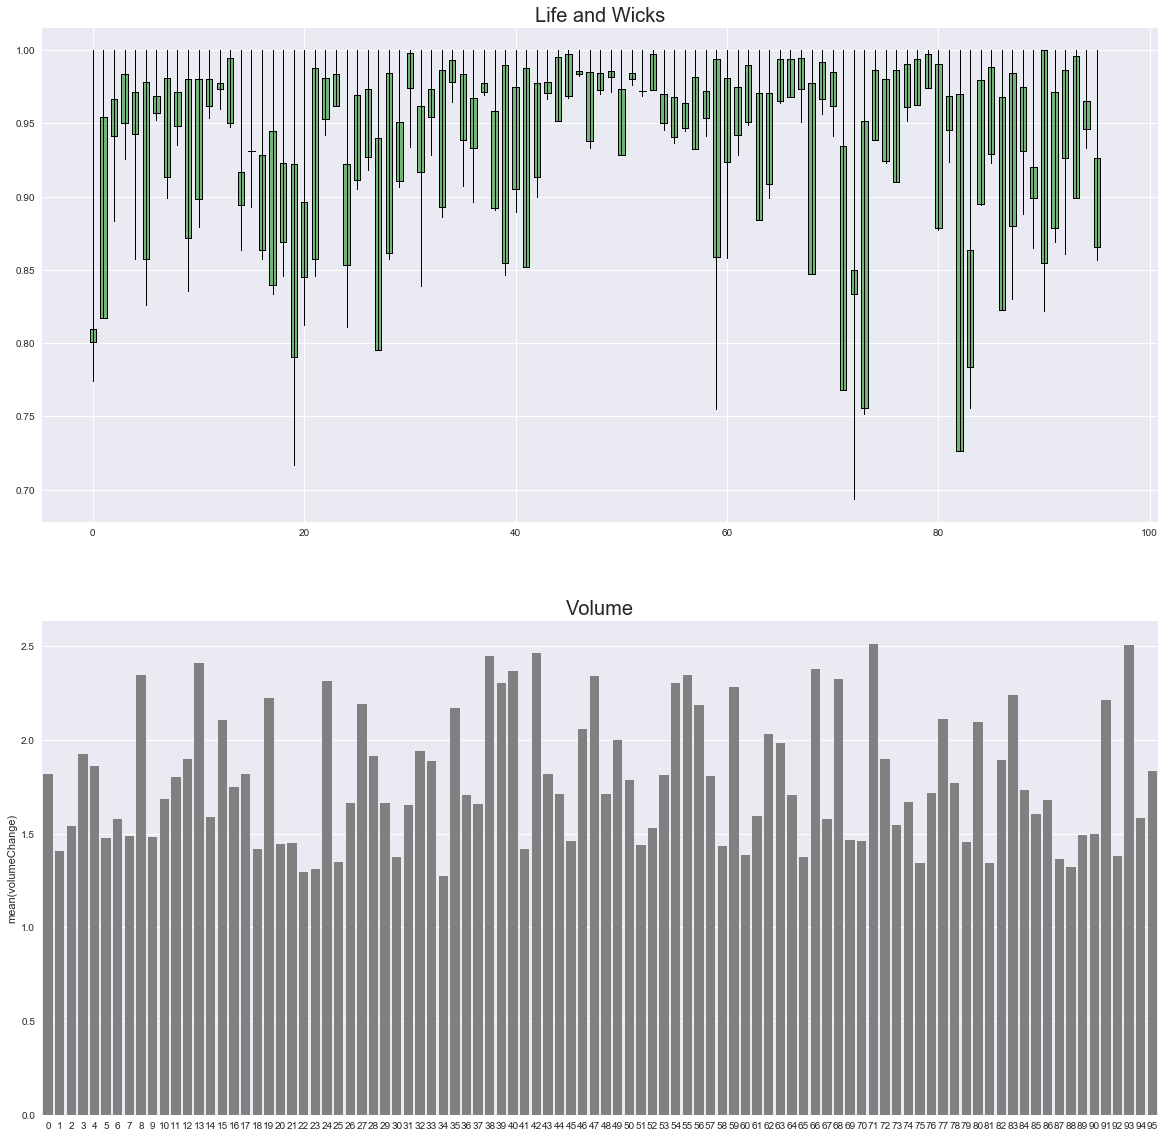

In [73]:
# Change the input 'i' to see the various clusters.
# I have named each cluster according to how best to describe them

i = 0

title = {0: 'Life and Wicks', 1: 'Death and Hammers', 2:'Big Life Small Life', 3: 'Volatile Indecision', 4: 'Big Death Small Death', 5: 'Blood and Indecision' }

# i=0 - Life and Wicks
# i=1 - Death and Hammers
# i=2 - Big Life Small Life
# i=3 - Volatile Indecision
# i=4 - Big Death Small Death
# i=5 - Blood and Indecision

temp_df0 = temp_df[temp_df['k_labels']==i]
temp_df0.reset_index(inplace=True)

length = temp_df0.shape[0]
part1, part2, part3, part4, part5, part6, part7, part8 = (round(length/8), round(2*length/8), round(3*length/8), round(4*length/8), round(5*length/8), round(6*length/8), round(7*length/8), round(8*length/8))

fig, (ax1, ax2) = plt.subplots(figsize= [20, 20], nrows=2, ncols=1)
ax1.set_title(title[i], fontsize=20)
candlestick2_ohlc(ax1, temp_df0['Open%'], temp_df0['High%'], temp_df0['Low%'], temp_df0['Close%'], colorup='g', colordown='r', alpha=0.5, width=0.6)
ax2.set_title('Volume', fontsize=20)
sns.barplot(x= temp_df0.index ,y=temp_df0['volumeChange'], color='gray', ax=ax2)

Unfortunately (again), my matplotlib skills are quite limited, which prevents me from being able to plot the volume bars on the same chart as the candlesticks. The volume bars and the candlesticks and also not aligned so we will need to count and eyeball manually for now.

Now you must be wondering, 'So what if we have all these fancy clusters? How can we make use of this information?'

Well what if, on top of there being a hidden relationship between candlesticks, there was a hidden relationship and sequence between each candlestick cluster as well? Some hidden rule that the markets seem to follow? 

Sounds a lot like the transition matrix from the Hidden Markov Model.

In [75]:
# First we count how many times each K-Means label transitioned to the next K-Means label

from collections import Counter
a = df['k_labels']
b = np.zeros((6,6))
for (x,y), c in Counter(zip(a, a[1:])).items():
    b[x-1,y-1] = c
print(b)

[[ 16.  28.  44.  23.   0.  23.]
 [ 27.  52.  18.  23.  18.  30.]
 [ 32.  40.  23.  28.   6.  20.]
 [ 34.  29.  27.  42.  13.  17.]
 [  3.   7.  14.  13.   0.   1.]
 [ 22.  12.  23.  33.   1.   5.]]


In [79]:
# Next we convert these counts into probabilities of the sum of each of its respective row
tempList1 = []
for i, j in enumerate(b[:]):
    c = b[:][i]/sum(b[:][i])
    tempList1.append(c)

tempList1

[array([ 0.11940299,  0.20895522,  0.32835821,  0.17164179,  0.        ,
         0.17164179]),
 array([ 0.16071429,  0.30952381,  0.10714286,  0.13690476,  0.10714286,
         0.17857143]),
 array([ 0.2147651 ,  0.26845638,  0.15436242,  0.18791946,  0.04026846,
         0.13422819]),
 array([ 0.20987654,  0.17901235,  0.16666667,  0.25925926,  0.08024691,
         0.10493827]),
 array([ 0.07894737,  0.18421053,  0.36842105,  0.34210526,  0.        ,
         0.02631579]),
 array([ 0.22916667,  0.125     ,  0.23958333,  0.34375   ,  0.01041667,
         0.05208333])]

In [85]:
# Check if the sum of each row is equal to 1
tempList1[5].sum()

1.0

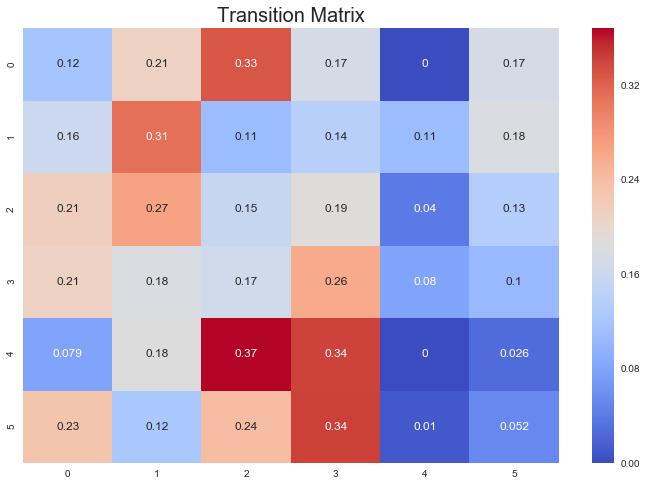

In [93]:
# Visualise the transition matrix as a heat map
plt.figure(figsize=[12, 8])
plt.title('Transition Matrix', fontsize=20)
sns.heatmap(tempList1, annot=True, cmap='coolwarm')

The probabilities displayed in the transition matrix above represents how likely it is to transition from state[x] (row) to state[y] (column)

Now lets recall our 6 clusters

**i=0 - Life and Wicks**

**i=1 - Death and Hammers**

**i=2 - Big Life Small Life**

**i=3 - Volatile Indecision**

**i=4 - Big Death Small Death**

**i=5 - Blood and Indecision**

Lets illustrate how to use the transition matrix with an example - Looking at the top row, a candlestick in the 'Life and Wicks' cluster will most likely transition into the 'Big Life Small Life' cluster (33% chance). Furthermore, there is also a 12% chance that the next candlestick will stay in the 'Life and Wicks' cluster, giving us a 42% chance gains for holding our positions through the day.

Interestingly enough there is a 0% chance of the next candlestick being from the 'Big Death Small Death' cluster, which limits our downside significantly. Coupled with a total of 34% chance to end up with an indecision and lesser 'death' candlestick, it would be wise to hold off selling a position while the 'Life and Wicks' candlestick is forming.

The next interesting observation is that the 'Volatile Indecision' candlestick cluster will result in green candlesticks next more often than red candlesticks.

Also, there is a very high chance of profits if one were to enter into a position at the end of a 'Big Death Small Death' cluster.

### Whats next?

I would like to explore the common technical analysis techniques using this model and test their effectiveness.

The big question to ask is - Are the knowledge passed down for technical analysis backed by evidence or simply 'thy will be done'? 